In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import zipfile

In [2]:
import xarray as xr
import rioxarray as rxr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import earthpy as et
import regionmask
import contextily as cx

In [3]:
from utils.constants import *
from utils.countries import *
from utils.functions import *

In [4]:
os.chdir(ABSOLUTE_FOLDER_REPOSITORY)

In [5]:
nuts = load_nuts_mask(level=3, subset=[*EU, 'UK'])

In [6]:
def plot_year_snapshot(df, variable, time, cmap):
    
    df = df[df.YEAR == time]
    
    plot_map(df, variable, cmap = cmap)

In [7]:
def plot_month_snapshot(df, variable, time, cmap):
    
    df = df[df.TIMESTAMP == time]
    
    plot_map(df, variable, cmap = cmap)

## Import data

In [8]:
climate_matrix = pd.read_csv(os.path.join(FOLDER_PROCESSED_DATA, 'climate_matrix.csv'))

In [9]:
climate_matrix

NUTS_ID   TIMESTAMP   spi01   spi03   spi06   spi12  lfi    tmax  \
0        AL011  2001-01-01  0.1130 -0.2670 -0.9130 -1.0900  0.0   5.730   
1        AL012  2001-01-01  0.2905  0.3215 -0.5500 -0.7295  NaN  13.260   
2        AL013  2001-01-01  0.3270 -0.0620 -0.2765 -0.8495  0.0   3.682   
3        AL014  2001-01-01  0.3320  0.1080 -0.2270 -0.5860  0.0   9.742   
4        AL015  2001-01-01  0.5720  0.5610  0.4480 -0.2130  0.0   7.825   
...        ...         ...     ...     ...     ...     ...  ...     ...   
326363   UKN0C  2018-12-01 -0.1840 -0.6060 -0.4980 -0.0320  0.0   7.831   
326364   UKN0D  2018-12-01  0.0745 -0.4475 -0.8955 -1.0365  0.0   8.103   
326365   UKN0E  2018-12-01  0.2660 -0.0830 -0.7940 -1.0500  NaN     NaN   
326366   UKN0F  2018-12-01 -0.1770 -0.5460 -0.5080 -0.3010  0.0   7.857   
326367   UKN0G  2018-12-01  0.1370 -0.6310 -0.9380 -0.6630  0.0   7.840   

        fapar    sma  
0         NaN -0.324  
1         NaN  0.735  
2         NaN  0.573  
3         NaN  0.785  
4         NaN  0.701  
...       ...    ...  
326363    NaN -0.214  
326364    NaN  0.153  
326365    NaN  0.165  
326366    NaN  0.156  
326367    NaN  0.008  

[326368 rows x 10 columns]

In [10]:
# fapar_estimations = pd.read_csv(os.path.join(FOLDER_PROCESSED_DATA, 'new_old_fapar_data.csv'))
# fapar_estimations = fapar_estimations[['NUTS_ID', 'TIMESTAMP', 'new_old_fapar']]
# climate_matrix = pd.merge(climate_matrix, fapar_estimations, how = 'left', on = ['NUTS_ID','TIMESTAMP'])
# climate_matrix['fapar_combined'] = climate_matrix.fapar.combine_first(climate_matrix.new_old_fapar)

In [11]:
columns_to_keep = [
    'NUTS_ID',
    'TIMESTAMP',
    'spi01',
    'spi03',
    'spi06',
    'spi12',
    'lfi',
    'tmax',
    'fapar',
    'sma'
]

climate_matrix = climate_matrix[columns_to_keep]

In [12]:
# climate_matrix = pd.merge(nuts, climate_matrix, how = 'left', on = ['NUTS_ID'])

In [13]:
climate_matrix['YEAR'] = climate_matrix.TIMESTAMP.str[:4]
climate_matrix['MONTH'] = climate_matrix.TIMESTAMP.str[5:7]

In [14]:
variables = ['spi01','spi03','spi06','spi12','lfi','tmax','fapar','sma']

df1 = climate_matrix.groupby(['NUTS_ID','YEAR'])[variables].min().reset_index()
df2 = climate_matrix.groupby(['NUTS_ID','YEAR'])[variables].mean().reset_index()
df3 = climate_matrix.groupby(['NUTS_ID','YEAR'])[variables].median().reset_index()
df4 = climate_matrix.groupby(['NUTS_ID','YEAR'])[variables].max().reset_index()

for variable in variables:
    df1 = df1.rename(columns={variable: variable + '_min'})
    df2 = df2.rename(columns={variable: variable + '_mean'})
    df3 = df3.rename(columns={variable: variable + '_median'})
    df4 = df4.rename(columns={variable: variable + '_max'})

climate_matrix_y = df1.copy()
climate_matrix_y = pd.merge(climate_matrix_y, df2, how = 'left', on = ['NUTS_ID','YEAR'])
climate_matrix_y = pd.merge(climate_matrix_y, df3, how = 'left', on = ['NUTS_ID','YEAR'])
climate_matrix_y = pd.merge(climate_matrix_y, df4, how = 'left', on = ['NUTS_ID','YEAR'])

## Drought indicator for Agricoltural sector

Source: EDO combined drought indicator (CDI) - Weak version

Inspired by warning CDI value looking at SPI03, SMA and FAPAR (estimated 2012 backwards).
- Weak drought indicator agri: -2 <= spi03 < -1 and sma <= -1
- Strong drought indicator agri: spi03 <= -2 and sma <= -1

In [15]:
climate_matrix['drg_agr_w'] = ((climate_matrix['spi03']) > -2) & ((climate_matrix['spi03']) <= -1) & ((climate_matrix['sma']) <= -1)
df5 = climate_matrix.groupby(['NUTS_ID','YEAR'])['drg_agr_w'].sum().reset_index()
climate_matrix_y = pd.merge(climate_matrix_y, df5, how = 'left', on = ['NUTS_ID','YEAR'])

In [16]:
df5b = climate_matrix[['NUTS_ID','YEAR','MONTH','drg_agr_w']].set_index(['NUTS_ID','YEAR','MONTH']).unstack(2)
df5b = df5b.fillna(0).astype(int).reset_index()
df5b.columns = ['NUTS_ID','YEAR',*['drg_agr_w_' + str(x).zfill(2) for x in list(range(1,13))]]
climate_matrix_y = pd.merge(climate_matrix_y, df5b, how = 'left', on = ['NUTS_ID','YEAR'])

In [17]:
climate_matrix['drg_agr_s'] = ((climate_matrix['spi03']) <= -2) & ((climate_matrix['sma']) <= -1)
df6 = climate_matrix.groupby(['NUTS_ID','YEAR'])['drg_agr_s'].sum().reset_index()
climate_matrix_y = pd.merge(climate_matrix_y, df6, how = 'left', on = ['NUTS_ID','YEAR'])

In [18]:
df6b = climate_matrix[['NUTS_ID','YEAR','MONTH','drg_agr_s']].set_index(['NUTS_ID','YEAR','MONTH']).unstack(2)
df6b = df6b.fillna(0).astype(int).reset_index()
df6b.columns = ['NUTS_ID','YEAR',*['drg_agr_s_' + str(x).zfill(2) for x in list(range(1,13))]]
climate_matrix_y = pd.merge(climate_matrix_y, df6b, how = 'left', on = ['NUTS_ID','YEAR'])

## Drought indicator for Manufacturing sector

- attempt to model a hydrological drought, more severe than agricultural drought
- main argument: low flow levels affect the energy provision, cooling of production processes, pric elevels, transport and shipping, low precipitation per se doesnt lead to a drought that majorly affects manufacturing
- additional points to consider e.g. provision of timber, which might be affected by drought, potentially modelled by FAPAR

***
- Weak drought indicator manufacturing: -2 <= spi06 < -1 and lfi >= 0.25
- Strong drought indicator manufacturing: spi06 <= -2 and lfi >= 0.25

In [19]:
climate_matrix['drg_man_w'] = ((climate_matrix['spi06']) > -2) & ((climate_matrix['spi06']) <= -1) & ((climate_matrix['lfi']) >= 0.25)
df7 = climate_matrix.groupby(['NUTS_ID','YEAR'])['drg_man_w'].sum().reset_index()
climate_matrix_y = pd.merge(climate_matrix_y, df7, how = 'left', on = ['NUTS_ID','YEAR'])

In [20]:
df7b = climate_matrix[['NUTS_ID','YEAR','MONTH','drg_man_w']].set_index(['NUTS_ID','YEAR','MONTH']).unstack(2)
df7b = df7b.fillna(0).astype(int).reset_index()
df7b.columns = ['NUTS_ID','YEAR',*['drg_man_w_' + str(x).zfill(2) for x in list(range(1,13))]]
climate_matrix_y = pd.merge(climate_matrix_y, df7b, how = 'left', on = ['NUTS_ID','YEAR'])

In [21]:
climate_matrix['drg_man_s'] = ((climate_matrix['spi06']) <= -2) & ((climate_matrix['lfi']) >= 0.25)
df8 = climate_matrix.groupby(['NUTS_ID','YEAR'])['drg_man_s'].sum().reset_index()
climate_matrix_y = pd.merge(climate_matrix_y, df8, how = 'left', on = ['NUTS_ID','YEAR'])

In [22]:
df8b = climate_matrix[['NUTS_ID','YEAR','MONTH','drg_man_s']].set_index(['NUTS_ID','YEAR','MONTH']).unstack(2)
df8b = df8b.fillna(0).astype(int).reset_index()
df8b.columns = ['NUTS_ID','YEAR',*['drg_man_s_' + str(x).zfill(2) for x in list(range(1,13))]]
climate_matrix_y = pd.merge(climate_matrix_y, df8b, how = 'left', on = ['NUTS_ID','YEAR'])

In [23]:
# climate_matrix['drg_agr_sf'] = ((climate_matrix['spi03']) <= -2) & ((climate_matrix['sma']) <= -1) & ((climate_matrix['fapar']) <= -1)
# df7 = climate_matrix.groupby(['NUTS_ID','YEAR'])['drg_agr_sf'].sum().reset_index()
# climate_matrix_y = pd.merge(climate_matrix_y, df7, how = 'left', on = ['NUTS_ID','YEAR'])

In [24]:
climate_matrix = pd.merge(nuts, climate_matrix, how = 'left', on = ['NUTS_ID'])
climate_matrix_y = pd.merge(nuts, climate_matrix_y, how = 'left', on = ['NUTS_ID'])

In [25]:
# plot_time_snapshot(climate_matrix_y[climate_matrix_y.CNTR_CODE == 'RO'], 'drg_strong', '2007', 'plasma')
# plot_time_snapshot(climate_matrix_y[climate_matrix_y.CNTR_CODE == 'ES'], 'drg_strong', '2005', 'plasma')
# plot_time_snapshot(climate_matrix_y[climate_matrix_y.CNTR_CODE == 'PT'], 'drg_strong', '2005', 'plasma')

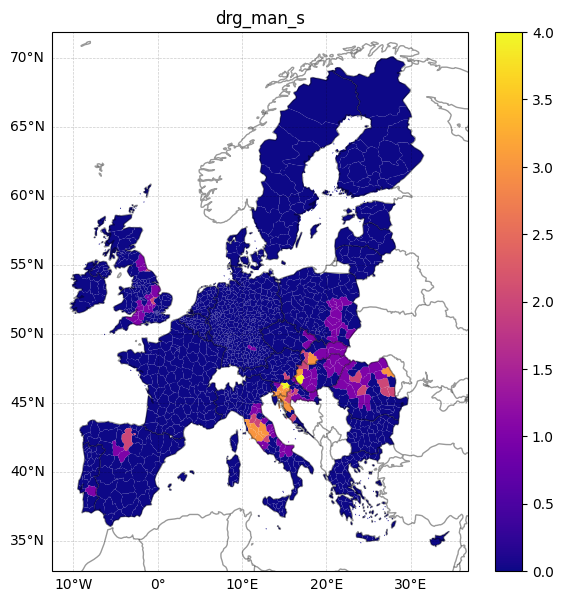

In [26]:
plot_year_snapshot(climate_matrix_y, 'drg_man_s', '2012', 'plasma')

# Yearly SPI

In [27]:
aux_df = climate_matrix.copy(deep=True)

# Filter in only January data
aux_df = aux_df[pd.to_datetime(aux_df.TIMESTAMP).dt.month==1]

# Extract YEAR out of DATE
aux_df = aux_df.assign(YEAR=pd.to_datetime(aux_df.TIMESTAMP).dt.year.astype(str))

aux_df = aux_df[["YEAR", "NUTS_ID", "spi12"]].set_index(["NUTS_ID", "YEAR"]).rename(columns={"spi12": "spi12_yearly"})

In [28]:
aux_df
climate_matrix_y = pd.merge(climate_matrix_y, aux_df, how = 'left', on = ['NUTS_ID','YEAR'])
climate_matrix_y

CNTR_CODE NUTS_ID            NUTS_NAME  \
0            AT   AT111     Mittelburgenland   
1            AT   AT111     Mittelburgenland   
2            AT   AT111     Mittelburgenland   
3            AT   AT111     Mittelburgenland   
4            AT   AT111     Mittelburgenland   
...         ...     ...                  ...   
23953        UK   UKN0G  Fermanagh and Omagh   
23954        UK   UKN0G  Fermanagh and Omagh   
23955        UK   UKN0G  Fermanagh and Omagh   
23956        UK   UKN0G  Fermanagh and Omagh   
23957        UK   UKN0G  Fermanagh and Omagh   

                                                geometry  YEAR  spi01_min  \
0      POLYGON ((4821838.771 2726165.971, 4806751.431...  2001     -1.920   
1      POLYGON ((4821838.771 2726165.971, 4806751.431...  2002     -2.470   
2      POLYGON ((4821838.771 2726165.971, 4806751.431...  2003     -1.675   
3      POLYGON ((4821838.771 2726165.971, 4806751.431...  2004     -1.720   
4      POLYGON ((4821838.771 2726165.971, 4806751.431...  2005     -1.014   
...                                                  ...   ...        ...   
23953  POLYGON ((3214939.132 3602580.729, 3213799.010...  2014     -2.780   
23954  POLYGON ((3214939.132 3602580.729, 3213799.010...  2015     -0.967   
23955  POLYGON ((3214939.132 3602580.729, 3213799.010...  2016     -1.730   
23956  POLYGON ((3214939.132 3602580.729, 3213799.010...  2017     -2.070   
23957  POLYGON ((3214939.132 3602580.729, 3213799.010...  2018     -0.945   

       spi03_min  spi06_min  spi12_min  lfi_min  ...  drg_man_s_04  \
0         -1.670     -1.450     -1.400      NaN  ...             0   
1         -1.660     -2.005     -1.980      NaN  ...             0   
2         -2.350     -2.170     -2.275      NaN  ...             0   
3         -1.725     -2.515     -2.275      NaN  ...             0   
4         -1.225     -2.295     -1.945      NaN  ...             0   
...          ...        ...        ...      ...  ...           ...   
23953     -1.150     -1.160     -0.437      0.0  ...             0   
23954     -0.383      0.022     -0.071      0.0  ...             0   
23955     -2.550     -1.490     -0.835      0.0  ...             0   
23956     -2.210     -2.420     -2.140      0.0  ...             0   
23957     -1.180     -1.620     -1.130      0.0  ...             0   

       drg_man_s_05  drg_man_s_06  drg_man_s_07  drg_man_s_08  drg_man_s_09  \
0                 0             0             0             0             0   
1                 0             0             0             0             0   
2                 0             0             0             0             0   
3                 0             0             0             0             0   
4                 0             0             0             0             0   
...             ...           ...           ...           ...           ...   
23953             0             0             0             0             0   
23954             0             0             0             0             0   
23955             0             0             0             0             0   
23956             0             0             0             0             0   
23957             0             0             0             0             0   

       drg_man_s_10  drg_man_s_11  drg_man_s_12  spi12_yearly  
0                 0             0             0       -0.9395  
1                 0             0             0       -1.6050  
2                 0             0             0        0.6805  
3                 0             0             0       -2.2750  
4                 0             0             0       -0.2440  
...             ...           ...           ...           ...  
23953             0             0             0       -0.4370  
23954             0             0             0        0.6600  
23955             0             0             0        1.9840  
23956             0             0             0       -1.4800  
23957     

### Upload dataset

In [29]:
climate_matrix_y.columns

Index(['CNTR_CODE', 'NUTS_ID', 'NUTS_NAME', 'geometry', 'YEAR', 'spi01_min',
       'spi03_min', 'spi06_min', 'spi12_min', 'lfi_min', 'tmax_min',
       'fapar_min', 'sma_min', 'spi01_mean', 'spi03_mean', 'spi06_mean',
       'spi12_mean', 'lfi_mean', 'tmax_mean', 'fapar_mean', 'sma_mean',
       'spi01_median', 'spi03_median', 'spi06_median', 'spi12_median',
       'lfi_median', 'tmax_median', 'fapar_median', 'sma_median', 'spi01_max',
       'spi03_max', 'spi06_max', 'spi12_max', 'lfi_max', 'tmax_max',
       'fapar_max', 'sma_max', 'drg_agr_w', 'drg_agr_w_01', 'drg_agr_w_02',
       'drg_agr_w_03', 'drg_agr_w_04', 'drg_agr_w_05', 'drg_agr_w_06',
       'drg_agr_w_07', 'drg_agr_w_08', 'drg_agr_w_09', 'drg_agr_w_10',
       'drg_agr_w_11', 'drg_agr_w_12', 'drg_agr_s', 'drg_agr_s_01',
       'drg_agr_s_02', 'drg_agr_s_03', 'drg_agr_s_04', 'drg_agr_s_05',
       'drg_agr_s_06', 'drg_agr_s_07', 'drg_agr_s_08', 'drg_agr_s_09',
       'drg_agr_s_10', 'drg_agr_s_11', 'drg_agr_s_12', 'drg_ma

In [30]:
columns_to_keep = [
    'NUTS_ID',
    'YEAR',
    'spi01_min', 'spi03_min', 'spi06_min', 'spi12_min', 'lfi_min', 'tmax_min', 'fapar_min', 'sma_min',
    'spi01_mean', 'spi03_mean', 'spi06_mean','spi12_mean', 'lfi_mean', 'tmax_mean', 'fapar_mean', 'sma_mean',
    'spi01_median', 'spi03_median', 'spi06_median', 'spi12_median','lfi_median', 'tmax_median', 'fapar_median', 'sma_median',
    'spi01_max', 'spi03_max', 'spi06_max', 'spi12_max', 'lfi_max', 'tmax_max', 'fapar_max', 'sma_max',
    'drg_agr_w', 'drg_agr_s',
    'drg_man_w', 'drg_man_s',
    'drg_agr_w_01', 'drg_agr_w_02','drg_agr_w_03', 'drg_agr_w_04', 'drg_agr_w_05', 'drg_agr_w_06','drg_agr_w_07', 'drg_agr_w_08', 'drg_agr_w_09', 'drg_agr_w_10','drg_agr_w_11', 'drg_agr_w_12',
    'drg_agr_s_01', 'drg_agr_s_02','drg_agr_s_03', 'drg_agr_s_04', 'drg_agr_s_05', 'drg_agr_s_06','drg_agr_s_07', 'drg_agr_s_08', 'drg_agr_s_09', 'drg_agr_s_10','drg_agr_s_11', 'drg_agr_s_12',
    'drg_man_w_01', 'drg_man_w_02','drg_man_w_03', 'drg_man_w_04', 'drg_man_w_05', 'drg_man_w_06','drg_man_w_07', 'drg_man_w_08', 'drg_man_w_09', 'drg_man_w_10','drg_man_w_11', 'drg_man_w_12',
    'drg_man_s_01', 'drg_man_s_02','drg_man_s_03', 'drg_man_s_04', 'drg_man_s_05', 'drg_man_s_06','drg_man_s_07', 'drg_man_s_08', 'drg_man_s_09', 'drg_man_s_10','drg_man_s_11', 'drg_man_s_12'
    ,'spi12_yearly'
]

climate_matrix_y = climate_matrix_y[columns_to_keep]

climate_matrix_y

NUTS_ID  YEAR  spi01_min  spi03_min  spi06_min  spi12_min  lfi_min  \
0       AT111  2001     -1.920     -1.670     -1.450     -1.400      NaN   
1       AT111  2002     -2.470     -1.660     -2.005     -1.980      NaN   
2       AT111  2003     -1.675     -2.350     -2.170     -2.275      NaN   
3       AT111  2004     -1.720     -1.725     -2.515     -2.275      NaN   
4       AT111  2005     -1.014     -1.225     -2.295     -1.945      NaN   
...       ...   ...        ...        ...        ...        ...      ...   
23953   UKN0G  2014     -2.780     -1.150     -1.160     -0.437      0.0   
23954   UKN0G  2015     -0.967     -0.383      0.022     -0.071      0.0   
23955   UKN0G  2016     -1.730     -2.550     -1.490     -0.835      0.0   
23956   UKN0G  2017     -2.070     -2.210     -2.420     -2.140      0.0   
23957   UKN0G  2018     -0.945     -1.180     -1.620     -1.130      0.0   

       tmax_min  fapar_min  sma_min  ...  drg_man_s_04  drg_man_s_05  \
0        -2.107        NaN   -2.905  ...             0             0   
1         0.998        NaN   -3.424  ...             0             0   
2         0.208        NaN   -1.161  ...             0             0   
3         0.575        NaN    0.149  ...             0             0   
4         0.166        NaN   -0.242  ...             0             0   
...         ...        ...      ...  ...           ...           ...   
23953     7.054     -0.874   -2.216  ...             0             0   
23954     6.723     -1.067   -1.457  ...             0             0   
23955     7.754     -0.217   -1.091  ...             0             0   
23956     6.973     -1.599   -1.466  ...             0             0   
23957     5.341     -0.879   -1.356  ...             0             0   

       drg_man_s_06  drg_man_s_07  drg_man_s_08  drg_man_s_09  drg_man_s_10  \
0                 0             0             0             0             0   
1                 0             0             0             0             0   
2                 0             0             0             0             0   
3                 0             0             0             0             0   
4                 0             0             0             0             0   
...             ...           ...           ...           ...           ...   
23953             0             0             0             0             0   
23954             0             0             0             0             0   
23955             0             0             0             0             0   
23956             0             0             0             0             0   
23957             0             0             0             0             0   

       drg_man_s_11  drg_man_s_12  spi12_yearly  
0                 0             0       -0.9395  
1                 0             0       -1.6050  
2                 0             0        0.6805  
3                 0             0       -2.2750  
4                 0             0       -0.2440  
...             ...           ...           ...  
23953             0             0       -0.4370  
23954             0             0        0.6600  
23955             0             0        1.9840  
23956             0             0       -1.4800  
23957             0             0        0.6800  

[23958 rows x 87 columns]

In [31]:
climate_data_yearly_processed = 'climate_matrix_yearly.csv'
climate_matrix_y.to_csv(os.path.join(FOLDER_PROCESSED_DATA, climate_data_yearly_processed), index = False)